# Nonlinear Twiss
This Jupyter notebook introduces SciBmad's parametric nonlinear normal form routines, with the goal of familiarizing users with Truncated Power Series Algebra (TPSA) methods in accelerator physics. Various "nonlinear Twiss" calculations are made using the Electron Storage Ring of the Electron-Ion Collider. E.g., we will compute the beta function as a Taylor series in the momentum deviation $\delta$, and can also do so as a Taylor series in variations of some parameters, e.g. sextupole strengths.

Map-based perturbation theory is an approach to perturbation theory introduced by Dragt and Finn, and developed in great detail for accelerator physics applications by Forest back in the early 90s. It is the only fully general and self consistent way to compute all such important quantities of the map, without any approximations up to the truncation order of the Taylor series. *All* quantities computed by SciBmad use this most powerful and general formalism.

In [1]:
from juliacall import Main as jl
jl.seval('using SciBmad')
import matplotlib.pyplot as plt
import numpy as np

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
jl.include("../../lattices/esr-v6.3.1.jl"); # ESR lattice in lattices directory of SciBmad repo
ring = jl.ring

Let's start by just calling `twiss`:

In [3]:
tw = jl.twiss(ring)
tw

Twiss:
 coasting_beam = true
 tunes[1:3]    = [Qx, Qy, slip]
 table         has columns: beamline_index, name, s, phi_1, beta_1, alpha_1, phi_2, beta_2, alpha_2, phi_3, gamma_c, c11, c12, c21, c22, orbit_x, orbit_px, orbit_y, orbit_py, orbit_z, orbit_pz

We can plot the betas:

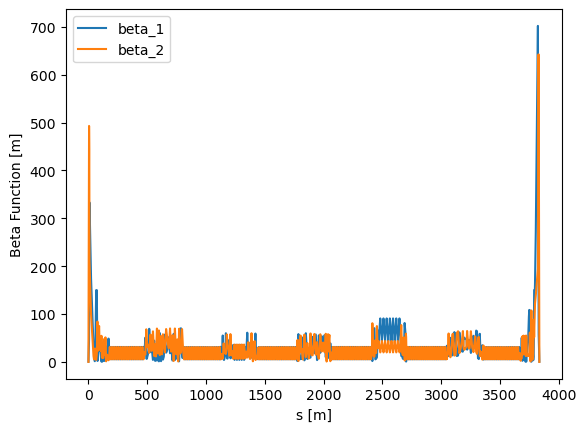

In [4]:
t = tw.table
plt.plot(t.s, t.beta_1, label='beta_1')
plt.plot(t.s, t.beta_2, label='beta_2')
plt.xlabel('s [m]')
plt.ylabel('Beta Function [m]')
plt.legend()
plt;

Note that the plot shows $\beta_a$ and $\beta_b$ using a Teng-Edwards coupling formalism. 

Now let's look at the closed orbit at the beginning:

In [5]:
t.orbit_x[0]

TPS64{GTPSA.Dynamic}:
Descriptor(NV=6, MO=1)
 COEFFICIENT             ORDER   EXPONENTS
 4.7436551156208019E-08    1     0 0  0 0  0 1


Woah, what is this? This is actually a Taylor series in the *last* phase space coordinate, $\delta$  (note that there are NO RF cavities in the ring!). In particular, this basically says that at the beginning of the ring (which is the IP here), the closed orbit is,

$$
x_{co}=0 + 4.7436547838232309\times10^{-8}\delta \ .
$$

Therefore, we have explicitly that $\frac{\partial x_{co}}{\partial\delta} =  4.7436547838232309\times10^{-8}$ . This is exactly the **periodic dispersion!**

We can extract the periodic dispersion from the orbit using the tools provided by SciBmad's GTPSA.jl package. To extract this particular monomial coefficient in the Taylor series, we can use the syntax:

In [6]:
eta_x_0 = t.orbit_x[0][[0,0,0,0,0,1]] # eta_x at the beginning
eta_x_0

4.743655115620802e-08

To apply this at every element in the `orbit_x` array,

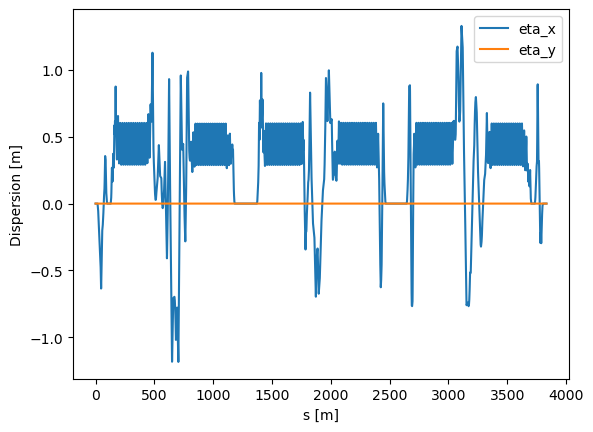

In [7]:
eta_x = np.array([x[[0,0,0,0,0,1]] for x in t.orbit_x])
eta_y = np.array([x[[0,0,0,0,0,1]] for x in t.orbit_y])

# Now can plot the dispersions:
plt.plot(t.s, eta_x, label='eta_x')
plt.plot(t.s, eta_y, label='eta_y')
plt.xlabel('s [m]')
plt.ylabel('Dispersion [m]')
plt.legend()
plt;

So that's pretty cool. But we said earlier that we want to do things like $\frac{\partial\beta}{\partial\delta}$, or even $\frac{\partial^2x_{co}}{\partial\delta^2}=\frac{\partial\eta_x}{\partial\delta}$ ("second-order" dispersion). Well, when `twiss` is called in the manner we did above, our TPSA defaults to 6 variables to 1st order. Lattice functions, such as $\beta$, are first order quantities, as well as the dispersion. To get these higher order quantities, we must specify a TPSA of higher order. We can do that easily:

In [8]:
D2 = jl.Descriptor(6, 2); # 6 variables to 2nd order
tw = jl.twiss(ring, GTPSA_descriptor=D2)

Now if we look at the closed orbit:

In [9]:
t = tw.table
t.orbit_x[0]

TPS64{GTPSA.Dynamic}:
Descriptor(NV=6, MO=2)
 COEFFICIENT             ORDER   EXPONENTS
 4.7436551156208019E-08    1     0 0  0 0  0 1
-6.9849628570685152E+00    2     0 0  0 0  0 2


Our closed orbit Taylor series is one order higher! The monomial coefficient specified by 
`0   0   0   0   0   2`
corresponds to $\frac{1}{2!}\frac{\partial^2x_{co}}{\partial\delta^2}=\frac{1}{2!}\frac{\partial\eta_x}{\partial\delta}$, the second-order dispersion!

Let's now plot both second-order dispersions around the ring:

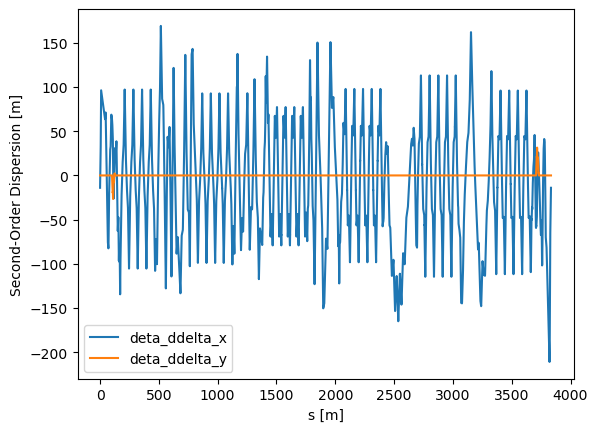

In [10]:
deta_ddelta_x = np.array([2*x[[0,0,0,0,0,2]] for x in t.orbit_x]) # Multiply by 2! to get only derivative
deta_ddelta_y = np.array([2*x[[0,0,0,0,0,2]] for x in t.orbit_y]) # Multiply by 2! to get only derivative

plt.plot(t.s, deta_ddelta_x, label='deta_ddelta_x')
plt.plot(t.s, deta_ddelta_y, label='deta_ddelta_y')
plt.xlabel('s [m]')
plt.ylabel('Second-Order Dispersion [m]')
plt.legend()
plt;

The beta functions now will also be TPSAs in $\delta$:

In [11]:
t.beta_1[0]

TPS64{GTPSA.Dynamic}:
Descriptor(NV=6, MO=2)
 COEFFICIENT             ORDER   EXPONENTS
 5.8999920399337424E-01    0     0 0  0 0  0 0
-4.1353894277617194E+00    1     0 0  0 0  0 1


Let's plot $\frac{\partial\beta/\partial\delta}{\beta}$ around the ring:

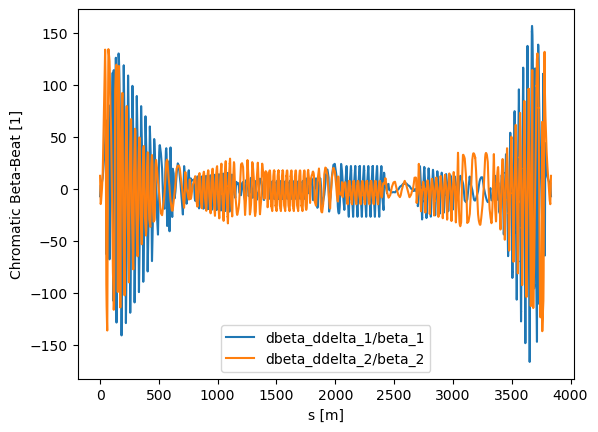

In [12]:
beta_1 = np.array([x[[0,0,0,0,0,0]] for x in t.beta_1])
beta_2 = np.array([x[[0,0,0,0,0,0]] for x in t.beta_2])
dbeta_ddelta_1 = np.array([x[[0,0,0,0,0,1]] for x in t.beta_1])
dbeta_ddelta_2 = np.array([x[[0,0,0,0,0,1]] for x in t.beta_2])

plt.plot(t.s, dbeta_ddelta_1/beta_1, label='dbeta_ddelta_1/beta_1')
plt.plot(t.s, dbeta_ddelta_2/beta_2, label='dbeta_ddelta_2/beta_2')
plt.xlabel('s [m]')
plt.ylabel('Chromatic Beta-Beat [1]')
plt.legend()
plt;

We can also write the Montague functions, which are phase invariants in achromatic regions, as

$$
W = \sqrt{A^2+B^2} \ , \ A=\frac{\partial\alpha}{\partial\delta}-\frac{\alpha}{\beta}\frac{\partial\beta}{\partial\delta} \ , \ B=\frac{1}{\beta}\frac{\partial\beta}{\partial\delta} \ .
$$

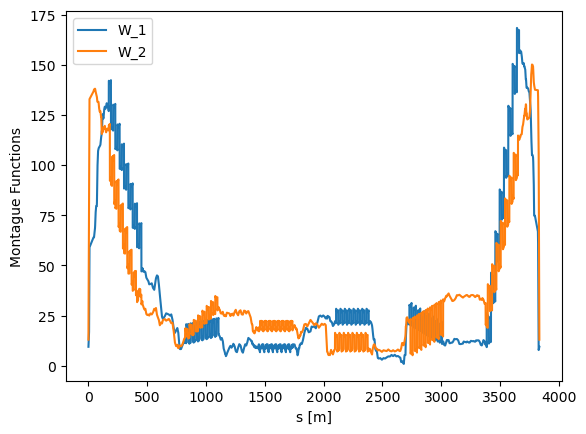

In [13]:
alpha_1 = np.array([x[[0,0,0,0,0,0]] for x in t.alpha_1])
alpha_2 = np.array([x[[0,0,0,0,0,0]] for x in t.alpha_2])
dalpha_ddelta_1 = np.array([x[[0,0,0,0,0,1]] for x in t.alpha_1])
dalpha_ddelta_2 = np.array([x[[0,0,0,0,0,1]] for x in t.alpha_2])

W_1 = np.sqrt((dalpha_ddelta_1-alpha_1/beta_1*dbeta_ddelta_1)**2 + (dbeta_ddelta_1/beta_1)**2)
W_2 = np.sqrt((dalpha_ddelta_2-alpha_2/beta_2*dbeta_ddelta_2)**2 + (dbeta_ddelta_2/beta_2)**2)

plt.plot(t.s, W_1, label='W_1')
plt.plot(t.s, W_2, label='W_2')
plt.xlabel('s [m]')
plt.ylabel('Montague Functions')
plt.legend()
plt;

In SciBmad, we don't have to stop at second order. We can go to *whatever* order we want. We could literally compute the 20th order dispersion if we'd like, simply specify a GTPSA descriptor with truncation order 20. Same for the Montague functions. 

Let's compute the "second order Montague functions" defined as

$$
W_2=\sqrt{A_2^2+B_2^2}\ , \ A_2=\frac{1}{2!}\left(\frac{\partial^2\alpha}{\partial\delta^2}-\frac{\alpha}{\beta}\frac{\partial^2\beta}{\partial\delta^2}\right)\ , \ B=\frac{1}{2!}\frac{1}{\beta}\frac{\partial^2\beta}{\partial\delta^2} \ .
$$

Note that this terminology may be confusing, because we need third order truncation to compute the "second order Montague functions".

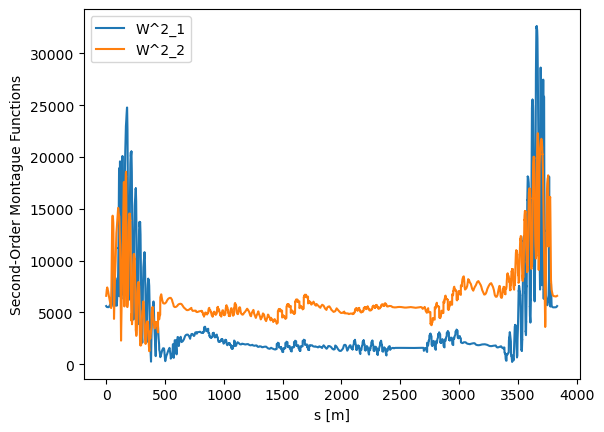

In [14]:
D3 = jl.Descriptor(6, 3) # 6 variables to 3rd order
tw = jl.twiss(ring, GTPSA_descriptor=D3)
t = tw.table
d2alpha_ddelta2_1 = np.array([x[[0,0,0,0,0,2]] for x in t.alpha_1])
d2alpha_ddelta2_2 = np.array([x[[0,0,0,0,0,2]] for x in t.alpha_2])
d2beta_ddelta2_1 = np.array([x[[0,0,0,0,0,2]] for x in t.beta_1])
d2beta_ddelta2_2 = np.array([x[[0,0,0,0,0,2]] for x in t.beta_2])

W2_1 = np.sqrt((d2alpha_ddelta2_1-alpha_1/beta_1*d2beta_ddelta2_1)**2 + (d2beta_ddelta2_1/beta_1)**2)
W2_2 = np.sqrt((d2alpha_ddelta2_2-alpha_2/beta_2*d2beta_ddelta2_2)**2 + (d2beta_ddelta2_2/beta_2)**2)

plt.plot(t.s, W2_1, label='W^2_1')
plt.plot(t.s, W2_2, label='W^2_2')
plt.xlabel('s [m]')
plt.ylabel('Second-Order Montague Functions')
plt.legend()
plt;

Finally, let's look at the amplitude-dependent tunes to 4th order. We can do this easily by getting the `tunes` field in the original `Twiss` structure:

In [15]:
jl.GTPSA.show_eps=1e-10 # Hide tiny monomials
tw.tunes

3-element StaticArraysCore.SVector{3, TPS64{GTPSA.Dynamic}}:
Descriptor(NV=6, MO=3)
INDEX  COEFFICIENT             ORDER   EXPONENTS
----------------------------------------------------
  1:   7.9999998080130461E-02    0     0 0  0 0  0 0
  1:   1.0002255976895222E+00    1     0 0  0 0  0 1
  1:   3.7403883448614374E+02    2     1 1  0 0  0 0
  1:  -1.5651507184369349E+04    2     0 0  1 1  0 0
  1:  -1.1047251314958793E+02    2     0 0  0 0  0 2
----------------------------------------------------
  2:   1.4000000380501454E-01    0     0 0  0 0  0 0
  2:   9.9981459749079094E-01    1     0 0  0 0  0 1
  2:  -1.5651507184369515E+04    2     1 1  0 0  0 0
  2:   2.4815299800462444E+03    2     0 0  1 1  0 0
  2:   1.2018396765130665E+02    2     0 0  0 0  0 2
----------------------------------------------------
  3:  -2.3344227124645047E+00    1     0 0  0 0  0 1
  3:   6.2846027792671553E+00    2     1 1  0 0  0 0
  3:   6.2820203888584834E+00    2     0 0  1 1  0 0
  3:  -2.1711023285

The amplitude dependent tunes in `tunes` are *always* in the phasor's basis, e.g. $\sqrt{J}e^{\pm \textrm{i}\phi}$. This is why you see the same orders for canonically-conjugate variables in each oscillation mode, because e.g. `1 1` corresponds to $(\sqrt{J}e^{-\textrm{i}\phi})^1(\sqrt{J}e^{+ \textrm{i}\phi})^1=J$. Therefore, here $\frac{\partial Q_x}{\partial J_y}=-1.5651507184369349\times 10^4$. Because there is coasting beam (no pseudo-harmonic oscillations in the longitudinal), the quantity $\delta$ is the invariant for that plane. 

Now let's see how the tunes vary with $\delta$. For this we will go to order 6, and use the `at` kwarg to specify computing the Twiss table at no elements to save time (will just compute the tunes):

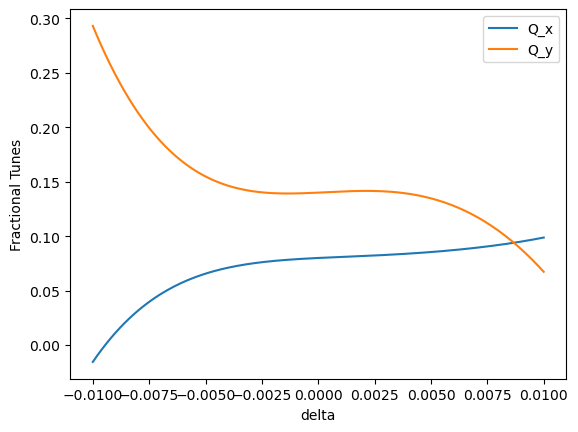

In [16]:
tw = jl.twiss(ring, GTPSA_descriptor=jl.Descriptor(6, 6), at=[])
delta = np.arange(-1, 1.01, 0.01)*10**-2

# We can evaluate these Taylor series like any other function:
Qx = tw.tunes[0]
Qy = tw.tunes[1]

Qxeval = [Qx(0,0,0,0,0,x) for x in delta]
Qyeval = [Qy(0,0,0,0,0,x) for x in delta]


plt.plot(delta, Qxeval, label='Q_x')
plt.plot(delta, Qyeval, label='Q_y')
plt.xlabel('delta')
plt.ylabel('Fractional Tunes')
plt.legend()
plt;